In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

import json
import requests
import openpyxl
import time

# https://medium.com/analytics-vidhya/fastest-way-to-install-geopandas-in-jupyter-notebook-on-windows-8f734e11fa2b

In [7]:
df = pd.read_csv("data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv")

In [8]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [9]:
df["date"] = pd.to_datetime(df["month"])
df["year"] = df["date"].dt.year

In [10]:
df.year.value_counts()

2020    23334
2019    22186
2018    21561
2017    20509
2021    18869
Name: year, dtype: int64

In [11]:
df_2020 = df[df["year"] == 2020]

In [12]:
df_2020["address"] = df_2020["block"] + " " + df_2020["street_name"]

C:\Users\User\AppData\Local\Temp/ipykernel_22232/2581190877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2020["address"] = df_2020["block"] + " " + df_2020["street_name"]


In [13]:
df_2020.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'date', 'year', 'address'],
      dtype='object')

In [144]:
df_2020_2 = df_2020[['address', 'town', 'flat_type', 'storey_range', 'resale_price']]

In [145]:
df_2020_2 = df_2020_2.reset_index(drop=True)

In [146]:
df_2020_2.head()

,address,town,flat_type,storey_range,resale_price
0,208 ANG MO KIO AVE 1,ANG MO KIO,3 ROOM,04 TO 06,265000.0
1,307C ANG MO KIO AVE 1,ANG MO KIO,3 ROOM,19 TO 21,470000.0
2,319 ANG MO KIO AVE 1,ANG MO KIO,3 ROOM,01 TO 03,230000.0
3,216 ANG MO KIO AVE 1,ANG MO KIO,3 ROOM,04 TO 06,280000.0
4,556 ANG MO KIO AVE 10,ANG MO KIO,3 ROOM,07 TO 09,220000.0


In [147]:
df_2020_2.flat_type.value_counts()

4 ROOM              9647
5 ROOM              5984
3 ROOM              5385
EXECUTIVE           1882
2 ROOM               418
1 ROOM                10
MULTI-GENERATION       8
Name: flat_type, dtype: int64

In [148]:
df_2020_2.shape

(23334, 5)

In [150]:
#df_2020_2.to_csv("data/df_2020_2.csv")

In [151]:
address_data = df_2020_2["address"]

In [144]:
df_address = pd.DataFrame(columns=["address","POSTAL", "X","Y","LATITUDE","LONGITUDE"])
#there is also 'LONGTITUDE' but that is just duplicate

In [145]:
df_address

,address,POSTAL,X,Y,LATITUDE,LONGITUDE


In [146]:
list_not_found = []

In [147]:
for address in address_data:
    query='https://developers.onemap.sg/commonapi/search?searchVal='+str(address)+'&returnGeom=Y&getAddrDetails=Y&pageNum=1'
    resp = requests.get(query)
    #sometimes get more than 1 search result, just picking one
    resp_results = json.loads(resp.content)["found"]
    if resp_results>0:
        data=json.loads(resp.content)['results'][0]
        data_postal = data["POSTAL"]
        row_append = pd.DataFrame({"address": [address], "POSTAL": [data["POSTAL"]],
                                   "X": [data["X"]], "Y": [data["Y"]], 
                                   "LATITUDE": [data["LATITUDE"]], "LONGITUDE": [data["LONGITUDE"]]})
        df_address= pd.concat([df_address, row_append])
    else:
        list_not_found.append(address)

In [148]:
df_address = df_address.reset_index(drop=True)

In [149]:
df_address.head()

,address,POSTAL,X,Y,LATITUDE,LONGITUDE
0,208 ANG MO KIO AVE 1,560208,29045.7150745867,38609.4830794428,1.36544495225352,103.842715047475
1,307C ANG MO KIO AVE 1,563307,29318.8660419369,38622.3167348057,1.36556100435161,103.845169497182
2,319 ANG MO KIO AVE 1,560319,29564.761900669,38572.4741130713,1.36511023350774,103.847379037914
3,216 ANG MO KIO AVE 1,560216,28911.0522399368,38692.6167905722,1.36619678831054,103.841505011903
4,556 ANG MO KIO AVE 10,560556,30705.0497700088,39337.8971205186,1.37203236308683,103.857625375797


In [150]:
df_address.to_csv("data/df_address.csv")

In [21]:
df_address = pd.read_csv("data/df_address.csv", index_col=0)

In [22]:
df_address.shape

(23194, 6)

In [23]:
df_address_2 = df_address.drop_duplicates()
df_address_2.shape

(7415, 6)

In [25]:
#len(list_not_found)

In [152]:
df_2020_3 = pd.merge(df_2020_2, df_address_2, on="address", how="inner")

In [153]:
df_2020_3.shape

(23194, 10)

In [154]:
df_2020_2.shape

(23334, 5)

In [155]:
df_2020_3.tail()

,address,town,flat_type,storey_range,resale_price,POSTAL,X,Y,LATITUDE,LONGITUDE
23189,263 YISHUN ST 22,YISHUN,3 ROOM,07 TO 09,270000.0,760263,28644.622339,46429.123568,1.436163,103.839111
23190,435 YISHUN AVE 6,YISHUN,4 ROOM,10 TO 12,358000.0,760435,29553.819873,44789.222553,1.421332,103.847281
23191,782 YISHUN RING RD,YISHUN,4 ROOM,01 TO 03,381000.0,760782,27826.484127,44859.342121,1.421966,103.831759
23192,322 YISHUN CTRL,YISHUN,5 ROOM,10 TO 12,530000.0,760322,28836.595482,45607.712146,1.428734,103.840836
23193,352 YISHUN RING RD,YISHUN,EXECUTIVE,04 TO 06,560000.0,760352,29289.834959,45356.500261,1.426463,103.844909


In [156]:
df_2020_3["LATITUDE"] =df_2020_3["LATITUDE"].astype('float')
df_2020_3["LONGITUDE"] =df_2020_3["LONGITUDE"].astype('float')
df_2020_3["X"] =df_2020_3["X"].astype('float')
df_2020_3["Y"] =df_2020_3["Y"].astype('float')

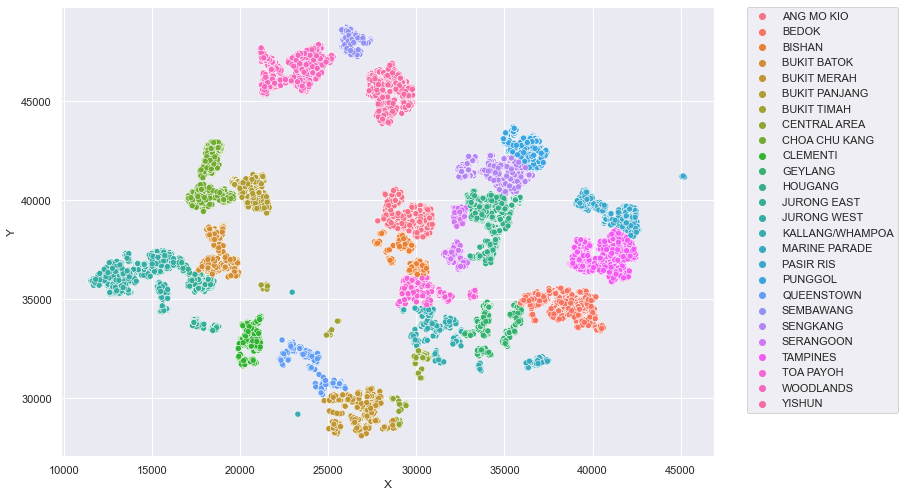

In [157]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=df_2020_3, x="X", y="Y", hue="town")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [158]:
df_2020_3.columns

Index(['address', 'town', 'flat_type', 'storey_range', 'resale_price',
       'POSTAL', 'X', 'Y', 'LATITUDE', 'LONGITUDE'],
      dtype='object')

In [171]:
geometry = [Point(xy) for xy in zip(df_2020_3.X, df_2020_3.Y)]
chunk = df_2020_3[['town', 'flat_type', 'storey_range', 'POSTAL', 'resale_price']]
crs = {'init': 'epsg:3414'}
df_2020_geo = gpd.GeoDataFrame(chunk, crs=crs, geometry=geometry)

C:\Users\User\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [172]:
df_2020_geo = df_2020_geo.to_crs(3414)

## MRT buffer 400m

In [32]:
# mrt locations https://www.kaggle.com/yxlee245/singapore-train-station-coordinates

In [33]:
mrt_locations = pd.read_csv("data/mrt_lrt_data.csv")

In [34]:
mrt_locations.head()

,station_name,type,lat,lng
0,Jurong East,MRT,1.333207,103.742308
1,Bukit Batok,MRT,1.349069,103.749596
2,Bukit Gombak,MRT,1.359043,103.751863
3,Choa Chu Kang,MRT,1.385417,103.744316
4,Yew Tee,MRT,1.397383,103.747523


In [54]:
mrt_locations.dtypes

station_name     object
type             object
lat             float64
lng             float64
dtype: object

In [37]:
#import descartes
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg

In [69]:
geometry = [Point(xy) for xy in zip(mrt_locations.lng, mrt_locations.lat)]
chunk = mrt_locations[['station_name', 'type']]
crs = {'init': 'epsg:4326'}
mrt_location_geo = gpd.GeoDataFrame(chunk, crs=crs, geometry=geometry)

C:\Users\User\anaconda3\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:68: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [46]:
#mrt_400_buffer = mrt_location_geo.buffer(500)

In [114]:
mrt_geo_m = mrt_location_geo.to_crs(3414)
print(mrt_geo_m.head())
mrt_400_buffer = mrt_geo_m.buffer(500)

    station_name type                     geometry
0    Jurong East  MRT  POINT (17871.469 35044.960)
1    Bukit Batok  MRT  POINT (18682.608 36798.872)
2   Bukit Gombak  MRT  POINT (18934.937 37901.739)
3  Choa Chu Kang  MRT  POINT (18095.151 40818.075)
4        Yew Tee  MRT  POINT (18452.098 42141.203)


In [118]:
mrt_400_buffer.dtype

In [119]:
mrt_400_buffer_geo = gpd.GeoDataFrame(mrt_geo_m[["station_name","type"]], geometry=mrt_400_buffer, crs='EPSG:3414')

In [120]:
mrt_400_buffer_geo.head()

,station_name,type,geometry
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995..."
1,Bukit Batok,MRT,"POLYGON ((19182.608 36798.872, 19180.200 36749..."
2,Bukit Gombak,MRT,"POLYGON ((19434.937 37901.739, 19432.529 37852..."
3,Choa Chu Kang,MRT,"POLYGON ((18595.151 40818.075, 18592.743 40769..."
4,Yew Tee,MRT,"POLYGON ((18952.098 42141.203, 18949.690 42092..."


<AxesSubplot:>

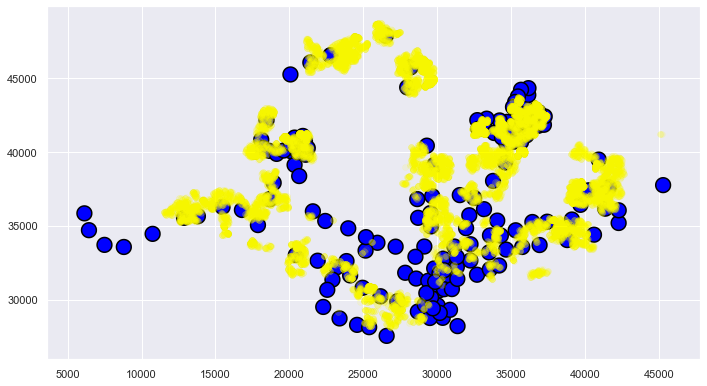

In [121]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

ax = mrt_400_buffer_geo.plot(color='blue', edgecolor='black', linewidths=1.5)
df_2020_geo.plot(ax=ax, color='yellow', alpha=0.1, linewidths=0.5)

## find houses that fall within mrt 400m - intersect

In [173]:
sjoin_op = gpd.sjoin(mrt_400_buffer_geo, df_2020_geo, op = 'contains', how='inner')

In [174]:
sjoin_op.shape

(14703, 9)

In [175]:
sjoin_op.head()

,station_name,type,geometry,index_right,town,flat_type,storey_range,POSTAL,resale_price
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995...",2712,JURONG EAST,5 ROOM,16 TO 18,600201,615000.0
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995...",2713,JURONG EAST,5 ROOM,07 TO 09,600201,580000.0
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995...",2715,JURONG EAST,5 ROOM,07 TO 09,600201,628000.0
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995...",2714,JURONG EAST,5 ROOM,07 TO 09,600201,600000.0
0,Jurong East,MRT,"POLYGON ((18371.469 35044.960, 18369.061 34995...",2711,JURONG EAST,5 ROOM,16 TO 18,600201,630000.0


In [195]:
df_2020_geo_yes= df_2020_geo[df_2020_geo["POSTAL"].isin(sjoin_op.POSTAL.unique())]

In [196]:
df_2020_geo_not = df_2020_geo[~(df_2020_geo["POSTAL"].isin(sjoin_op.POSTAL.unique()))]

In [197]:
df_2020_geo_yes["near_MRT"] = 1
df_2020_geo_not["near_MRT"] = 0

C:\Users\User\anaconda3\envs\geo_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [198]:
df_2020_geo_2 = pd.concat([df_2020_geo_yes, df_2020_geo_not], axis=0)

In [199]:
df_2020_geo_2.shape

(23194, 7)

In [200]:
df_2020_geo_2 = df_2020_geo_2.reset_index(drop=True)

In [201]:
df_2020_geo_2.head()

,town,flat_type,storey_range,POSTAL,resale_price,geometry,near_MRT
0,ANG MO KIO,3 ROOM,04 TO 06,560345,320000.0,POINT (29817.683 38835.289),1
1,ANG MO KIO,3 ROOM,04 TO 06,560345,320000.0,POINT (29817.683 38835.289),1
2,ANG MO KIO,4 ROOM,07 TO 09,560345,430000.0,POINT (29817.683 38835.289),1
3,ANG MO KIO,3 ROOM,01 TO 03,560345,330000.0,POINT (29817.683 38835.289),1
4,ANG MO KIO,3 ROOM,10 TO 12,560345,328000.0,POINT (29817.683 38835.289),1


In [203]:
import numpy as np
np.sqrt(23194)

152.2957648787385

In [214]:
df_2020_geo_2.resale_price.describe()

count    2.319400e+04
mean     4.521703e+05
std      1.546898e+05
min      1.400000e+05
25%      3.400000e+05
50%      4.250000e+05
75%      5.348880e+05
max      1.258000e+06
Name: resale_price, dtype: float64

<AxesSubplot:xlabel='flat_type', ylabel='resale_price'>

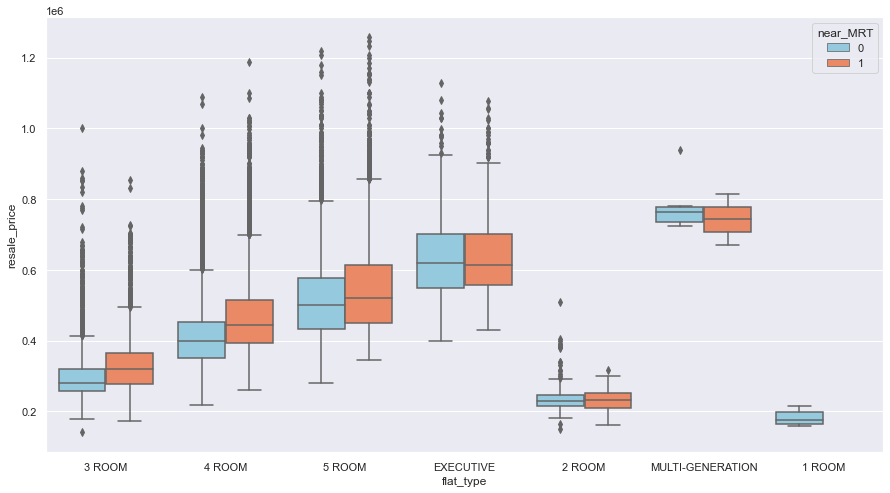

In [221]:
fig.set_size_inches(12, 8)
colors = ["skyblue","coral"]
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df_2020_geo_2, x="flat_type", y="resale_price", hue="near_MRT")

### Bedok

<AxesSubplot:xlabel='flat_type', ylabel='resale_price'>

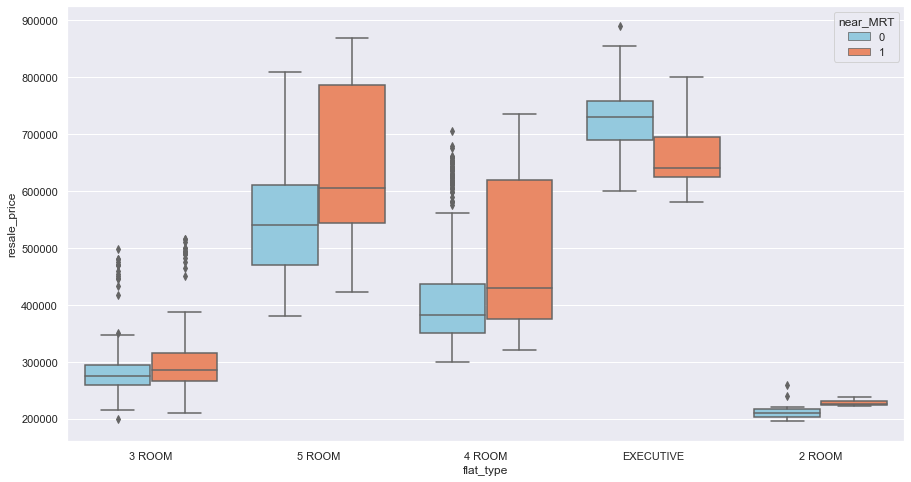

In [223]:
fig.set_size_inches(12, 8)
colors = ["skyblue","coral"]
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df_2020_geo_2[df_2020_geo_2["town"]=="BEDOK"], x="flat_type", y="resale_price", hue="near_MRT")

### Choa Chu Kang

<AxesSubplot:xlabel='flat_type', ylabel='resale_price'>

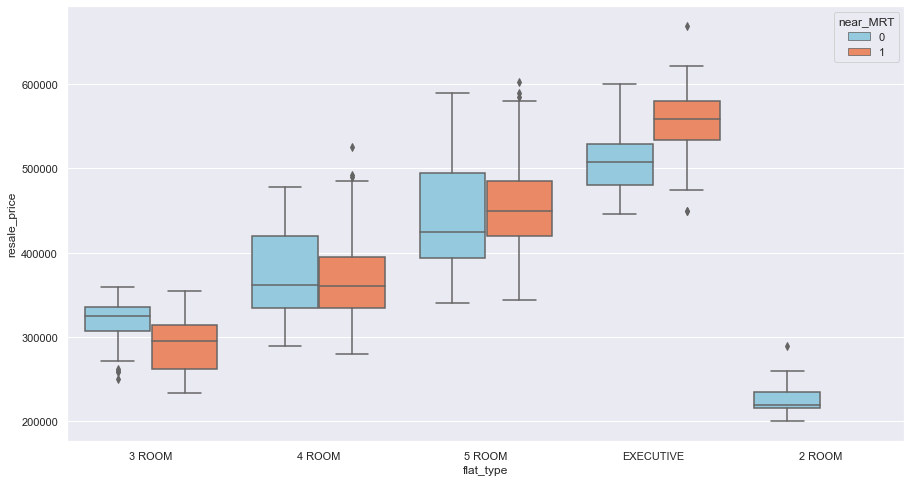

In [224]:
fig.set_size_inches(12, 8)
colors = ["skyblue","coral"]
sns.set_palette(sns.color_palette(colors))
sns.boxplot(data=df_2020_geo_2[df_2020_geo_2["town"]=="CHOA CHU KANG"], x="flat_type", y="resale_price", hue="near_MRT")

In [225]:
## build widget dropdown